In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import calcLattice
from calcLattice import make_lattice, reset
import draw
from draw import addTripod, make_figure
%matplotlib inline
import matplotlib as mpl
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from calcLattice import tiles, positions_list, orientations_list, types_list
from calcLattice import gluing_mapping
from symmetry_finding import *
global tiles, positions_list, orientations_list, types_list, gluing_mapping

In [4]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sph_projection_utils import *

In [5]:
all_pos = []
mappings = [{1:1, 2:2, 3:3, 4:1, 5:5, 6:6}, 
            {1:4, 2:3, 3:2, 4:1, 5:0, 6:6},
            {1:4, 2:3, 3:2, 4:1, 5:0, 6:7, 7:6, 8:8, 9:0}]
for mapping in mappings:
    gluing_mapping.clear()
    gluing_mapping.update(mapping)
    reset()
    make_lattice()
    all_pos.append(np.array(positions_list))

In [6]:
np_pos = all_pos[1]

In [7]:
N, _ = np_pos.shape
coords = np.zeros((N, N, 3))
for i, pos in enumerate(np_pos):
    coords[i, :, :2] = np_pos - np_pos[i]

In [8]:
phi, theta = xyz_to_phi_theta(coords)
np.fill_diagonal(phi, 0.)
np.fill_diagonal(theta, 0.)
r = np.linalg.norm(coords, axis=-1)

/home/tess/Dropbox/GitHubRepos/linus/sph_projection_utils.py:30: RuntimeWarning:

invalid value encountered in true_divide



In [9]:
ylms_cutoff = np.sum(ylms_within_r_cutoff(coords, 5.0)[0], axis=-1)

In [10]:
local_cutoff_norms = norm_sph(ylms_cutoff.T)

In [11]:
(kmeans_sph, sph_colors), (kmeans_norm, norms_colors) = get_sph_and_norm_clusters(coords, 5.0)

In [12]:
sph_clusters = {k: [] for k in range(20)}
for k,v in zip(sph_colors, np_pos):
    sph_clusters[k].append(v)

norms_clusters = {k: [] for k in range(10)}
for k,v in zip(norms_colors, np_pos):
    norms_clusters[k].append(v)

In [13]:
diff_vect_dict, diff_pairs_dict = get_cluster_function(sph_clusters, lambda a,b: a - b)
midpoint_dict, mid_pairs_dict = get_cluster_function(norms_clusters, lambda a,b: (a + b) / 2.)

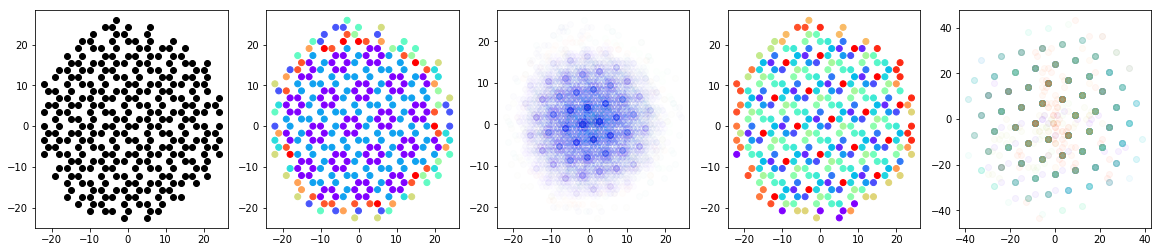

In [14]:
fig, axes = plt.subplots(1, 5, figsize=(20,4))
axes[0].plot(np_pos[:, 0].tolist(), np_pos[:, 1].tolist(), 'ko')
axes[1].scatter(np_pos[:, 0].tolist(), np_pos[:, 1].tolist(), c=norms_colors, cmap=cm.rainbow)
axes[3].scatter(np_pos[:, 0].tolist(), np_pos[:, 1].tolist(), c=sph_colors, cmap=cm.rainbow)
# Get translation vector between sph clusters (identical spherical harmonics)
for i, (cluster, diff_vectors) in enumerate(diff_vect_dict.items()):
    diff_vectors = np.array(diff_vectors)
    if len(diff_vectors) > 0:
        axes[4].plot(diff_vectors[:,0], diff_vectors[:,1],'o', alpha=0.05, color=cm.rainbow(i/20))
#     axes[3].plot(np_pos[:,0], np_pos[:,1], 'ko')
# mid_points = []
for i, (cluster, mid_points) in enumerate(midpoint_dict.items()):
    mid_points = np.array(mid_points)
    if len(mid_points) > 0:
        axes[2].plot(mid_points[:,0], mid_points[:,1],'o', alpha=0.01, color=cm.rainbow(i/10))
#     axes[1].plot(np_pos[:,0], np_pos[:,1], 'ko')

In [15]:
import networkx as nx

In [16]:
graph = nx.MultiGraph()  # Graph of everything
# add local env nodes
# for i,env in enumerate(local_cutoff_norms):
#     graph.add_node('e{}'.format(i), type="env")
# add cluster nodes
N_clusters = kmeans_norm.cluster_centers_.shape[0]
for i in range(N_clusters):
    graph.add_node('c{}'.format(i), type="cluster")
# for i,color in enumerate(norms_colors):
#     graph.add_edge('e{}'.format(i), 'c{}'.format(color))

In [17]:
# Add relations for environments
r = np.linalg.norm(coords, axis=-1)
indices = np.argwhere(r<=5.0)

In [18]:
for pair in indices:
    start, end = pair
    start_cluster, end_cluster = kmeans_norm.predict(local_cutoff_norms[[start, end]])
#     graph.add_edge('e{}'.format(start), 'e{}'.format(end))
    graph.add_edge('c{}'.format(start_cluster), 'c{}'.format(end_cluster))

/home/tess/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



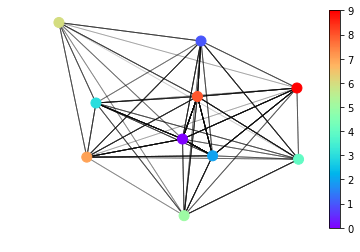

In [19]:
pos = nx.spring_layout(graph)
nodes = graph.nodes()
ec = nx.draw_networkx_edges(graph, pos, alpha=0.1)
nc = nx.draw_networkx_nodes(graph, pos,
                            nodelist=nodes, 
                            node_color=range(N_clusters),
                            cmap=cm.rainbow,
                            node_size=100, 
                            with_labels=True)
plt.colorbar(nc)
plt.axis('off')
plt.show()

In [20]:
nx.degree_centrality(graph)

{'c0': 268.88888888888886,
 'c1': 22.0,
 'c2': 242.0,
 'c3': 19.555555555555554,
 'c4': 17.11111111111111,
 'c5': 16.0,
 'c6': 10.222222222222221,
 'c7': 18.88888888888889,
 'c8': 39.77777777777778,
 'c9': 17.77777777777778}

In [21]:
import dash
from dash.dependencies import Input, Output
import dash_html_components as html

from dash_network import Network

In [22]:
app = dash.Dash(__name__)

app.scripts.config.serve_locally = True
app.css.config.serve_locally = True

In [23]:
plotly_nodes = [{'id': id} for id in list(graph.nodes())]
plotly_edges = [{'source': x, 'target': y} for x,y in list(graph.edges())]

In [24]:
app.layout = html.Div([
    html.H2('Force network'),
    Network(
        id='net',
        data={'nodes': plotly_nodes, 'links': plotly_edges},
    ),
    html.Div(id='output')
])

In [27]:
import jupyterlab_dash
viewer = jupyterlab_dash.AppViewer(port=8893, url="0.0.0.0")

In [28]:
viewer.show(app)

In [ ]:
viewer.terminate()